# My Search Engine
We have to index collections of documents and to build search-engines using the **PyTerrier** library.

We import the needed Python packages.

In [ ]:
!pip install --upgrade --no-cache-dir gdown
from bs4 import BeautifulSoup
import pandas as pd
!pip install python-terrier # installing pyterrier
import pyterrier as pt
if not pt.started():
  pt.init()
from typing import List
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.4
    Uninstalling gdown-4.6.4:
      Successfully uninstalled gdown-4.6.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.2 MB/s eta 0:00:00
     ━━━

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



## Part 1
We have to build a search engine for the book *Le Morte D’Arthur* by Thomas Malory and **improve the search-engines performance** (the higher the better). The book is divided into two volumes. Each chapter is a document with two fields: title of the chapter and corpus of the chapter. We only want to index the corpus of each chapter.

### 1.1.1
Download the data from the Drive link (code already provided).

In [ ]:
!gdown 1zHgvidy9FvhZvE68S0mXWkoF-hHMpiUL
!gdown 1VjpTkFcbfaLIi4TXVafokW9e_bvGnfut

Downloading...
From: https://drive.google.com/uc?id=1zHgvidy9FvhZvE68S0mXWkoF-hHMpiUL
To: /content/The Project Gutenberg eBook of Le Morte D’Arthur, Volume I (of II), by Thomas Malory.html
100% 964k/964k [00:00<00:00, 487MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VjpTkFcbfaLIi4TXVafokW9e_bvGnfut
To: /content/The Project Gutenberg eBook of Le Morte D’Arthur, Volume II (of II), by Thomas Malory.html
100% 1.10M/1.10M [00:00<00:00, 641MB/s]


### 1.1.2
Parse the HTML. **Part** of code already provided: follow the comments to complete the code.


In [ ]:
with open('The Project Gutenberg eBook of Le Morte D’Arthur, Volume I (of II), by Thomas Malory.html') as fp:
    vol1 = BeautifulSoup(fp, 'html.parser')
with open('The Project Gutenberg eBook of Le Morte D’Arthur, Volume II (of II), by Thomas Malory.html') as fp:
    vol2 = BeautifulSoup(fp, 'html.parser')

def clean_text(txt):
    words_to_put_space_before = [".",",",";",":","’","'"]
    words_to_lowercase = ["First","How","Some","Yet","Of","A","The","What","Fifth"]
    
    app = txt.replace("\n"," ")
    for word in words_to_put_space_before:
        app = app.replace(word," "+word)
    for word in words_to_lowercase:
        app = app.replace(word+" ",word.lower()+" ")
    return app.strip()

def parse_html(soup):
    titles = []
    texts = []
    for chapter in soup.find_all("h3"):
        chapter_title = chapter.text
        if "CHAPTER" in chapter_title:
            chapter_title = clean_text("".join(chapter_title.split(".")[1:]))
            titles.append(chapter_title)
            
            chapter_text = [p.text for p in chapter.findNextSiblings("p")]
            chapter_text = clean_text(" ".join(chapter_text))
            texts.append(chapter_text)
    return titles, texts

In [ ]:
#Extract all the chapters' titles and texts from the two volumes

vol1_titles, vol1_texts = parse_html(vol1)
vol2_titles, vol2_texts = parse_html(vol2)

#Transform the list into a pandas DataFrame (a PyTerrier friendly structure).
vol1_data = pd.DataFrame({"Chapter": vol1_titles, "Text": vol1_texts, "Vol":1})
vol2_data = pd.DataFrame({"Chapter": vol2_titles, "Text": vol2_texts, "Vol":2})
data = pd.concat([vol1_data, vol2_data], ignore_index=True)

# add "docno" column to identify the document 
data["docno"] = list(map(str, range(1, len(data)+1))) 

Print the first 8 rows of the DataFrame.

[comment]: <> (#SHOW_CELL#)

In [ ]:
display(data.head(8))

,Chapter,Text,Vol,docno
0,"first , how Uther Pendragon sent for the duke ...","It befell in the days of Uther Pendragon , whe...",1,1
1,how Uther Pendragon made war on the duke of Co...,"Then Ulfius was glad , and rode on more than a...",1,2
2,of the birth of King Arthur and of his nurture,Then Queen Igraine waxed daily greater and gre...,1,3
3,of the death of King Uther Pendragon,Then within two years King Uther fell sick of ...,1,4
4,"how Arthur was chosen king , and of wonders an...",Then stood the realm in great jeopardy long wh...,1,5
5,how King Arthur pulled out the sword divers times,"Now assay , said Sir Ector unto Sir Kay . And ...",1,6
6,"how King Arthur was crowned , and how he made ...",And at the feast of Pentecost all manner of me...,1,7
7,"how King Arthur held in Wales , at a Pentecost...","Then the king removed into Wales , and let cry...",1,8


### 1.1.3
We extract character's names from the **titles** only.

In [ ]:
all_characters = set()
def extract_character_names_from_string(string_to_parse):
    special_tokens = ["of","the","le","a","de"]

    remember = ""
    last_is_special_token = False

    tokens = string_to_parse.split(" ")
    characters_found = set()
    for i,word in enumerate(tokens):
        if word[0].isupper() or (remember!="" and word in special_tokens):
            #word = word.replace("'s","").replace("’s","")
            last_is_special_token = False
            if remember!="":
                if word in special_tokens:
                    last_is_special_token = True
                remember = remember+" "+word
            else: remember = word
        else:
            if remember!="":
                if last_is_special_token:
                    for tok in special_tokens:
                        remember = remember.replace(" "+tok,"")
                characters_found.add(remember)
            remember = ""
            last_is_special_token = False
    return characters_found

#all_characters = set([x for x in all_characters if x[-2:]!="'s"])

In [ ]:
#Extract all characters' names

all_characters = set().union(*list(data.Chapter\
                                   .apply(extract_character_names_from_string)))
print(all_characters)

{'Rome', 'King Pellam', 'Red Knight', 'Palomides', 'King of England', 'King Bors', 'Arthur', 'Lady Lionesse', 'Sir Carados', 'Galahad', 'Round Table', 'Sir Percivale', 'Joseph', 'Sir Lamorak de Galis', 'David', 'Epinogris', 'Boudwin', 'Sir Persant', 'Beale Pilgrim', 'Humber', 'York', 'Sir Agravaine', 'Great Royalty', 'Andred', 'King Evelake', 'Gaheris', 'Benwick', 'Sir Uwaine', 'Sir Kay', 'Sir Gareth', 'Carbonek', 'Accolon', 'Ulfius', 'Knights of the Round Table', 'Joyous Isle', 'Gawaine', 'Questing Beast', 'Sir Pedivere', 'King Solomon', 'King Pelles', 'Helin le Blank', 'Sir Mordred', 'Maiden of the Lake', 'Beale Isoud', 'Alisander', 'Queen Morgan le Fay', 'Sir Brian', 'Sir Epinogris', 'Bors', 'Maid of Astolat', 'Sir Safere', 'Pentecost', 'Joyous Gard', 'Almesbury', 'Sir Meliagaunce', 'Castle of Maidens', 'Sir Dagonet', 'Forest Perilous', 'Sir Gaheris', 'Sir Lionel', 'Chapel Perilous', 'Sir Bleoberis', 'Knight of the Black Launds', 'Gard', 'Lionel', 'King Bagdemagus', 'Elias', 'Melias

Print the names of all the kings (i.e. characters with `King` in their name).

[comment]: <> (#SHOW_CELL#)

In [ ]:
for name in all_characters:
    if "King" in name:
        print(name)

King Pellam
King of England
King Bors
King Evelake
King Solomon
King Pelles
King Bagdemagus
Maimed King
King
King Rience
King Brandegore
King Mordrains
King Leodegrance
King Howel of Brittany
King Mark
King Uriens
King Anguish of Ireland
King of the Land of Cameliard
King Pelleas
King Lot
King Arthur
King Ban
King Mark of Cornwall
King Lot of Orkney
King Pellinore


### 1.1.4
Some names refer to the same characters (e.g. `'Arthur' = 'King Arthur'`). A function is provided to extract the disambiguation dictionary: each key represents a name and the value represents the true character name (e.g. `{'Arthur': 'King-Arthur', 'King': 'King-Arthur', 'Bedivere':'Sir Bedivere'}`). Disambiguation sets, i.e. a list with sets representing the multiple names of a single character, are also provided.

> There may be some mistakes, but it does not matter (e.g. `'Cornwall' = 'King of Cornwall'`)

In [ ]:
disambiguate_to = {}
for x in all_characters:
    for y in all_characters:
        if x in y and x!=y:
            if x in disambiguate_to:
                previous_y = disambiguate_to[x]
                if len(y)>len(previous_y): disambiguate_to[x] = y
            else:
                disambiguate_to[x] = y
disambiguate_to.update({"King": "King Arthur",
                        "King of England": "King Arthur",
                        "Queen": "Queen Guenever",
                        "Sir Lancelot": "Sir Launcelot"})

disambiguate_sets = []
for x,y in disambiguate_to.items():
    inserted = False
    for z in disambiguate_sets:
        if x in z or y in z:
            z.add(x); z.add(y)
            inserted = True
    if not inserted:
        disambiguate_sets.append(set([x,y]))

### 1.1.5
Prepare the topics for the queries.

> Each character name (including alternative names) represents a topic.

In [ ]:
# init the topics with the ambiguous names
topics = disambiguate_sets.copy()  

# add the characters' name without ambiguity
for name in all_characters:
    ended = False
    for i, nick_names in enumerate(disambiguate_sets):
        if name in nick_names:
            break
        if i == len(disambiguate_sets)-1 and name not in nick_names:
            ended = True
    if ended:
        topics.append({name})

topics = pd.DataFrame({"qid": [ str(i) for i in range(1, len(topics)+1)],
                       "query": map(lambda x: ', '.join(x), topics)})

Print the first 5 rows.

[comment]: <> (#SHOW_CELL#)

In [ ]:
display(topics.head(5))

,qid,query
0,1,"Sir Palomides, Palomides"
1,2,"King Arthur, King of England, King, Arthur"
2,3,"Sir Galahad, Galahad"
3,4,"Round Table, Knights of the Round Table"
4,5,"Epinogris, Sir Epinogris"


### 1.1.6
Prepare the relevance scores for the queries.

> A document is considered relevant (1) if its **corpus** contains the character's name or one of its alternative names, otherwise is not relevant (0).

In [ ]:
def relevance_score(document_id: str,
                    topic_id: str,
                    dataframe: pd.DataFrame = data,
                    topic_dataframe: pd.DataFrame = topics) -> int:
    """This function checks if the document's corpus is relevant for the passed
    topic.

    Args:  
      - document_id (str): The document id.
      - topic_id (str): The topic id.
      - dataframe (pd.DataFrame): The dataframe where the document is stored.
                                  Default data.
      - topic_dataframe (pd.DataFrame): The dataframe with the topics.
                                        Default topics.

    Returns:
      - int : 1 If the document's corpus is relevant for the topic, otherwise 0.
    """
    corpus = dataframe[dataframe.docno == document_id].Text.values[0]
    topics = topic_dataframe[topic_dataframe.qid==topic_id]['query'].values[0].split(', ')
    for top in topics:
      if top in corpus:
        return 1
    return 0

qrels = data[["docno"]].merge(topics[["qid"]], how="cross")
qrels["label"] = qrels.apply(lambda x: relevance_score(x.docno, x.qid), axis=1)

Print the first and last row, and the shape of the DataFrame.

[comment]: <> (#SHOW_CELL#)

In [ ]:
print("The fist row:", "\n", qrels.head(1))
print()
print("The last row:", "\n", qrels.tail(1))
print()
print("The dataframe shape:", qrels.shape)

The fist row: 
   docno qid  label
0     1   1      0

The last row: 
       docno  qid  label
86012   503  171      0

The dataframe shape: (86013, 3)


### 1.1.7
We choose several preprocessing configurations (no more than 4).

For each of them, we construct an index on the `title` field.

For the last of them, we report the number of indexed documents and terms.

In [ ]:
prep = ["none-none", "none-Stopwords", "EnglishSnowballStemmer-none",
        "EnglishSnowballStemmer-Stopwords"] 
def create_index(preproc, folder, dataframe, field): 
    stemmer, stopwords = preproc.split("-") #preprocessing parameters
    pt_indexer = pt.DFIndexer(index_path=folder, stemmer=stemmer, #we don't use SetProperty
                              stopwords=stopwords,     #method to avoid
                              overwrite=True)          #the deprecation warning
    indexref = pt_indexer.index(dataframe[field], dataframe["docno"])
    return indexref
indexref = []
for i in range(len(prep)):
    folder = f'./ProjectGutenberg/prep-{prep[i]}/'
    indexref.append(create_index(prep[i], folder, data, "Chapter"))  

print(f"------ {prep[i]} index info ------")
print(f'Number of indexed documents: {pt.IndexFactory.of(indexref[i]).getCollectionStatistics().getNumberOfDocuments()}')
print(f'Number of indexed terms: {pt.IndexFactory.of(indexref[i]).getCollectionStatistics().getNumberOfUniqueTerms()}')

------ EnglishSnowballStemmer-Stopwords index info ------
Number of indexed documents: 503
Number of indexed terms: 807


### 1.1.8
We choose several weighting models (no more than 5).

For each of them, for each of the indices created in last step, we build a retrieval model.

In [ ]:
w_models = ["CoordinateMatch", "Tf", "TF_IDF", "BM25", "DFIC"]

def create_ret_model(index: pt.IndexRef,
                     wmodel: List[str]) -> pt.BatchRetrieve:
  """A function that creates a list of retrievers.

  Args:
    - index (pt.IndexRef): The index reference.
    - wmodel (List[str]): A list of all possible weighting models.

  Returns:
    - A list of retrievers given the index and the weighting models.
  """
  return list(map(lambda x: pt.BatchRetrieve(index, wmodel=x), wmodel))

retrieve_models = list(map(lambda x: create_ret_model(index=x, wmodel=w_models), indexref))

### 1.1.9
We choose several evaluation metrics (no more than 6) and put them in a list.

We add the following metrics to the list: __Recall at 5__, __Normalized Discounted Cumulative Gain at 20__, __Mean Average Precision__.

In [ ]:
eval_metrics = ['P_5', 'recip_rank', 'P_10', 'recall_5', 'ndcg_cut_20', 'map']

print(f'The metrics we\'ve chosen: {eval_metrics}')

The metrics we've chosen: ['P_5', 'recip_rank', 'P_10', 'recall_5', 'ndcg_cut_20', 'map']


### 1.1.10
For each index built in step 1.1.7, we run an experiment to obtain the values associated to each evaluation metrics specified in 1.1.8 for each of the weighting models chosen in 1.1.9.

In [ ]:
experiment = []
for i in range(len(indexref)):
  experiment.append(pt.Experiment(
      retrieve_models[i],
      topics,
      qrels,
      eval_metrics = eval_metrics,
      names = ["CoordinateMatch", "Tf", "TF_IDF", "BM25", "DFIC"],
      highlight="bold"))

### 1.1.11
For the last index constructed (i.e. corresponding to the last preprocessing chosen), we print out the PyTerrier table with the weighting models chosen by us on the rows and the evaluation metrics chosen by us + those specified by us on the columns. 

We highlight the best results in the result table.

In [ ]:
display(experiment[-1].data)

,name,P_5,recip_rank,P_10,recall_5,ndcg_cut_20,map
0,CoordinateMatch,0.437427,0.895906,0.298246,0.226685,0.445397,0.287738
1,Tf,0.312281,0.639020,0.219298,0.144317,0.314565,0.185345
2,TF_IDF,0.450292,0.890838,0.312865,0.234576,0.463553,0.298962
3,BM25,0.446784,0.893762,0.315205,0.231968,0.464375,0.297557
4,DFIC,0.453801,0.890838,0.310526,0.234099,0.462691,0.297686


### 1.1.12
We select the Top-4 configurations (preprocessing, weighting model) according to the Mean Average Precision (MAP), taking into account the results obtained in section 1.1.10.

For these 4 configurations, we provide the following plot (re-run the evaluations just for this configurations, to get the required evaluation metrics):

* Recall@k plot
    * the x axis represents the considered values for k: we consider k 𝜖 {1, 3, 5, 10, 20, 50}
    * the y axis represents the average Recall@k over all provided queries
    * each curve represents one of the 4 search engine configurations

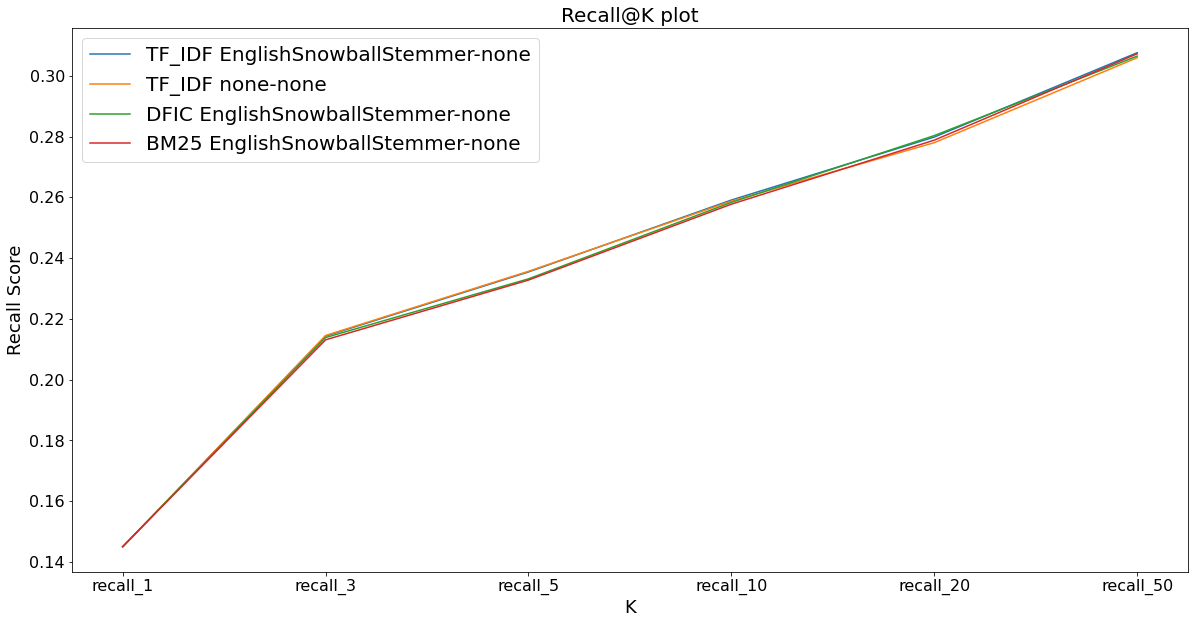

In [ ]:
results = pd.DataFrame() # init the final dataframe with our results

for i in range(len(experiment)):
  # for each experiment we filter the best 4 performances
  temp = experiment[i].data.sort_values(ascending=False, by="map").head(4)[["name", "map"]]
  temp["prep"] = prep[i] # store the pre-processing type in temp variable
  results = pd.concat([temp, results])

# take the overall best 4 performances
results = results.sort_values(ascending=False, by="map").head(4) 

# create a list with tuples (weighting model, pre-proc)
bests = list(zip(results.name, results.prep))

# from the above selcted configurations we take the best search engines
best_se = [retrieve_models[prep.index(model_prep)][w_models.index(wmodel)] for wmodel, model_prep in bests]

# init different metrics 
metrics = ["recall_1", "recall_3", "recall_5", "recall_10", "recall_20", "recall_50"]

# newely evaluate the relevance metrics for our best engines
exp = pt.Experiment(
    best_se,
    topics,
    qrels,
    eval_metrics = metrics,
    names=[ wmodel+' '+model_prep for wmodel, model_prep in bests]
)

# For the scalability of the program we graps the x-axis values from the metrics list
xx = list(map(int, [word.split("_")[-1] for word in metrics]))


exp = exp.set_index("name") # adjust for the indexes

# plot
ax = exp.T.plot(figsize = (20, 10), fontsize=16)

ax.set_title("Recall@K plot", fontdict={'fontsize':20})
ax.set_xlabel('K', fontdict={'fontsize':18})
ax.set_ylabel('Recall Score', fontdict={'fontsize':18})

ax.legend(prop = {'size': 20})
plt.show()

### 1.1.13
According only to the Recall@k plot, which is the best search engine configuration?

From the plot it is difficult to infer which search engine has better characteristics. In fact, it can be seen that the performance in terms of Recall@k is extremely similar among the best configurations. Instead, in the table we see that the search engine with slightly better performance is the one characterized by a weighting model of the type TF_IDF, without removal of stop words and with a simple EnglishSnowBall stemmer.

### 1.1.14
For the configuration you selected in Part 1.1.13, we provide an **example of the functioning** of our search engine.

The query should is: `King Mark of Cornwall`.

In [ ]:
# take the index of the best combo of weighting model + pre-proc
# in terms of Recall@50
best_wmd, best_mprep = exp["recall_50"].idxmax().split()

# search engine with the above configuration
best_model = retrieve_models[prep.index(best_mprep)][w_models.index(best_wmd)]

# show the ranking score for the query in our example
display(best_model.search("King Mark of Cornwall"))

,qid,docid,docno,rank,score,query
0,1,231,232,0,7.646867,King Mark of Cornwall
1,1,215,216,1,7.617933,King Mark of Cornwall
2,1,259,260,2,7.054165,King Mark of Cornwall
3,1,33,34,3,6.903879,King Mark of Cornwall
4,1,263,264,4,5.579589,King Mark of Cornwall
...,...,...,...,...,...,...
328,1,360,361,328,0.692548,King Mark of Cornwall
329,1,137,138,329,0.680346,King Mark of Cornwall
330,1,417,418,330,0.680346,King Mark of Cornwall
331,1,135,136,331,0.635553,King Mark of Cornwall


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>